# DSI19 Project 4 - EDA notebook
---

## Table of Contents

* [1. WNV Distribution](#chapter1)
* [2. Correlation](#chapter2)
    * [2.1 OneHotEncoding](#chapter2_1)
    * [2.2 Correlation Heatmap](#chapter2_2)
* [3. Species](#chapter3)
* [4. WNV/Mosquito Seasonality](#chapter4)
* [5. Traps/Mosquitos Distribution](#chapter5)
* [6. Weather Trends](#chapter6)
* [7. Spray Analysis](#chapter7)
* [8. Location Analysis](#chapter8)
* [9. EDA Conclusion and Takeaway](#chapter9)
* [10. Data Processing for Model](#chapter10)

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as datetime
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [14]:
# Read in data
train = pd.read_csv('../data/train_processed.csv')
test = pd.read_csv('../data/test_processed.csv')

# Change dates to datetime objects
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

## 1. WNV Distribution <a class="anchor" id="chapter1"></a>
---
To evaluate the performance of our prediction model, we first need to understand the distriution of the presence of the virus in our population.

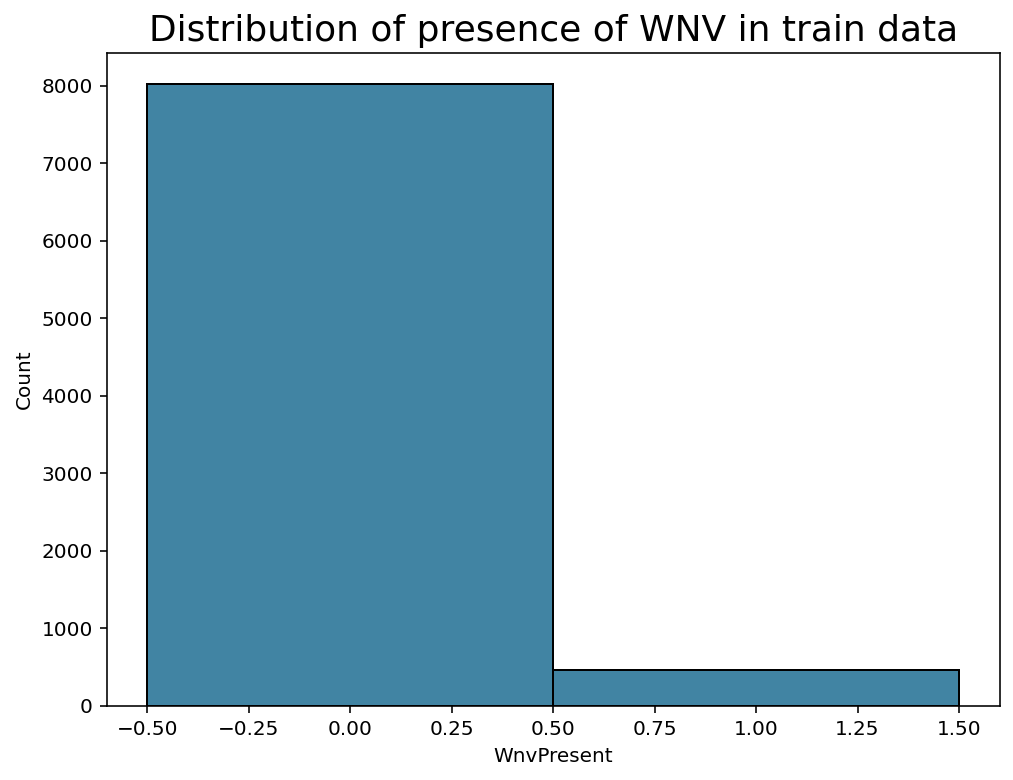

In [15]:
# Plot distribution of virus in train data
plt.figure(figsize=(8,6))
plt.title('Distribution of presence of WNV in train data', fontsize=18)
sns.histplot(data = train, x = 'WnvPresent', discrete = True, color = '#015B85');

In [16]:
print(train.value_counts('WnvPresent', normalize=True))

WnvPresent
0    0.946077
1    0.053923
dtype: float64


We observe a imbalance in the classes, with a 94.6% non-presence of the virus and 5.4% presence of the virus within the train data set. Therefore, accuracy as a metric for our model will not be a relevant metric. Instead, we will use `ROC AUC` and `F1` score instead.

## 2. Correlation <a class="anchor" id="chapter1"></a>
---
To gain further insights into the features in the data, we will look at the correlation and plot a heatmap. Before the correlation can be obtained, we will be using `OneHotEncoder` to convert object data types.

### 2.1 OneHotEncoding <a class="anchor" id="chapter2_1"></a>

As most of the data regarding location are stored within the coordinates data, only the following features will be encoded using `OneHotEncoder`.
- Species
- Trap
- coord

In [17]:
# Instantiate OneHotEncoder
ohe = OneHotEncoder(sparse=False, dtype=int)

In [18]:
# Create dataframe with params
train_ohe = train.copy()
ohe_params = ['Species', 'Trap', 'coord']


for param in ohe_params:
    train_ohe[param] = ohe.fit_transform(train_ohe[[param]])

In [19]:
train_ohe = train_ohe[['WnvPresent', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'geometry', 'coord', 'spray_14', 'Tavg',
       'PrecipTotal', 'R_Humid']]

### 2.2 Correlation Heatmap <a class="anchor" id="chapter2_2"></a>

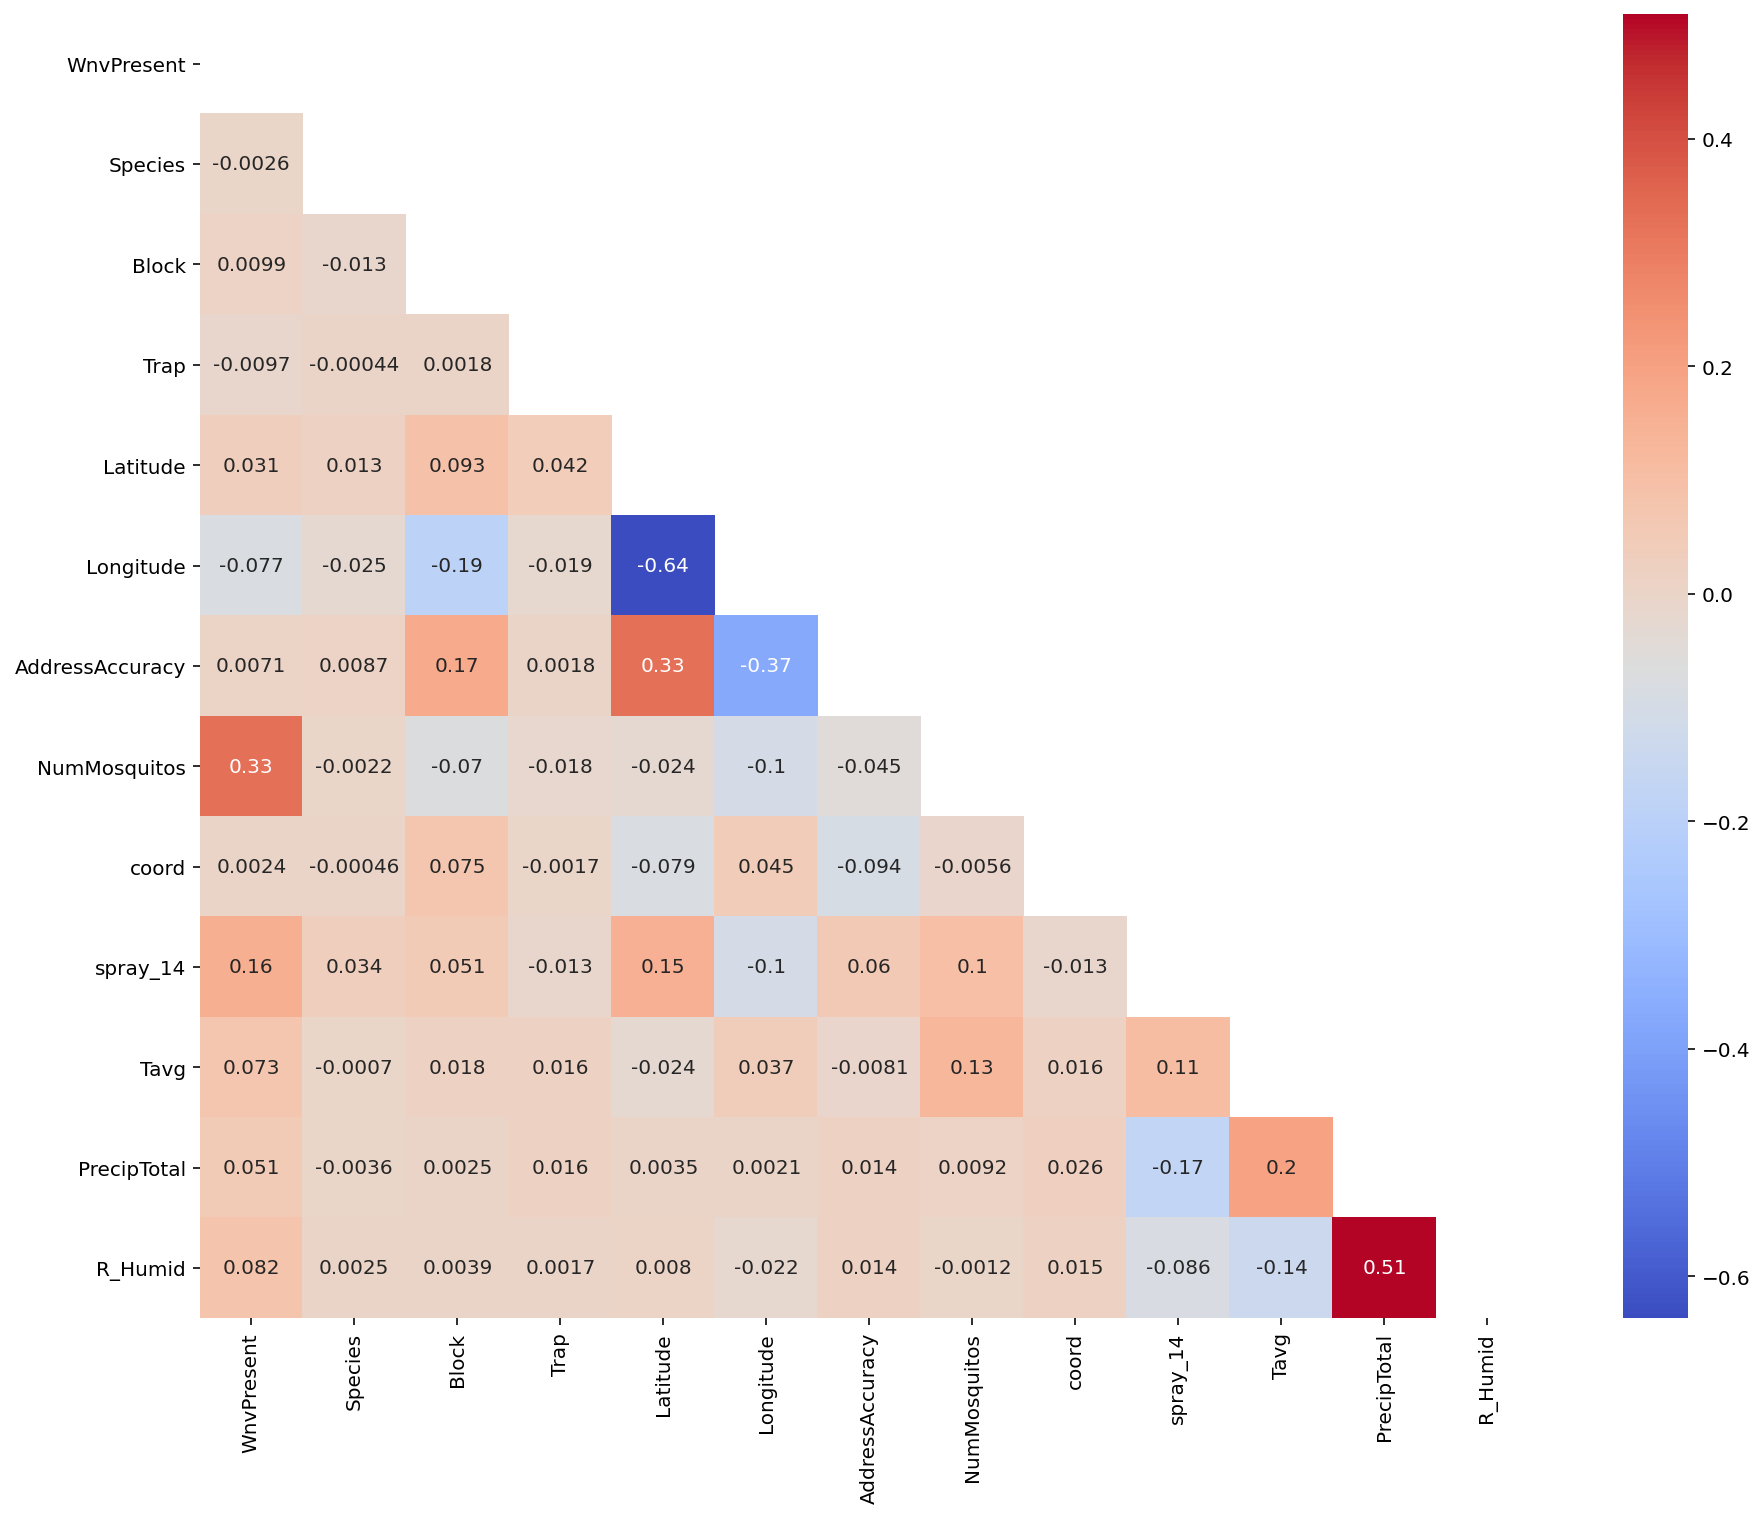

In [20]:
# Plot correlation heatmap
plt.figure(figsize=(15,12))
mask = np.triu(np.ones_like(train_ohe.corr(), dtype=bool))
sns.heatmap(train_ohe.corr(),annot=True, cmap='coolwarm', mask=mask);

Observations from correlation heatmap:
- No significant correlations between `WnvPresent` and other features other than `NumMosquitos`.
- This is expected as the higher the number of mosquitos, the higher probability of detecting the presence of the virus. 
- Due to the imbalanced classes and a very small percentage of the population having the WNV virus, the correlations are corresponingly also very small and difficult to interpret.

## 3. Species <a class="anchor" id="chapter3"></a>
---
This section will explore the `Species` feature in the data, detailing the species of mosquitos identifed in the traps.

In [21]:
# Obtain count of the different species of mosquitos
print(train.value_counts('Species'))

Species
CULEX PIPIENS/RESTUANS    3826
CULEX RESTUANS            2393
CULEX PIPIENS             1950
CULEX TERRITANS            216
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
dtype: int64


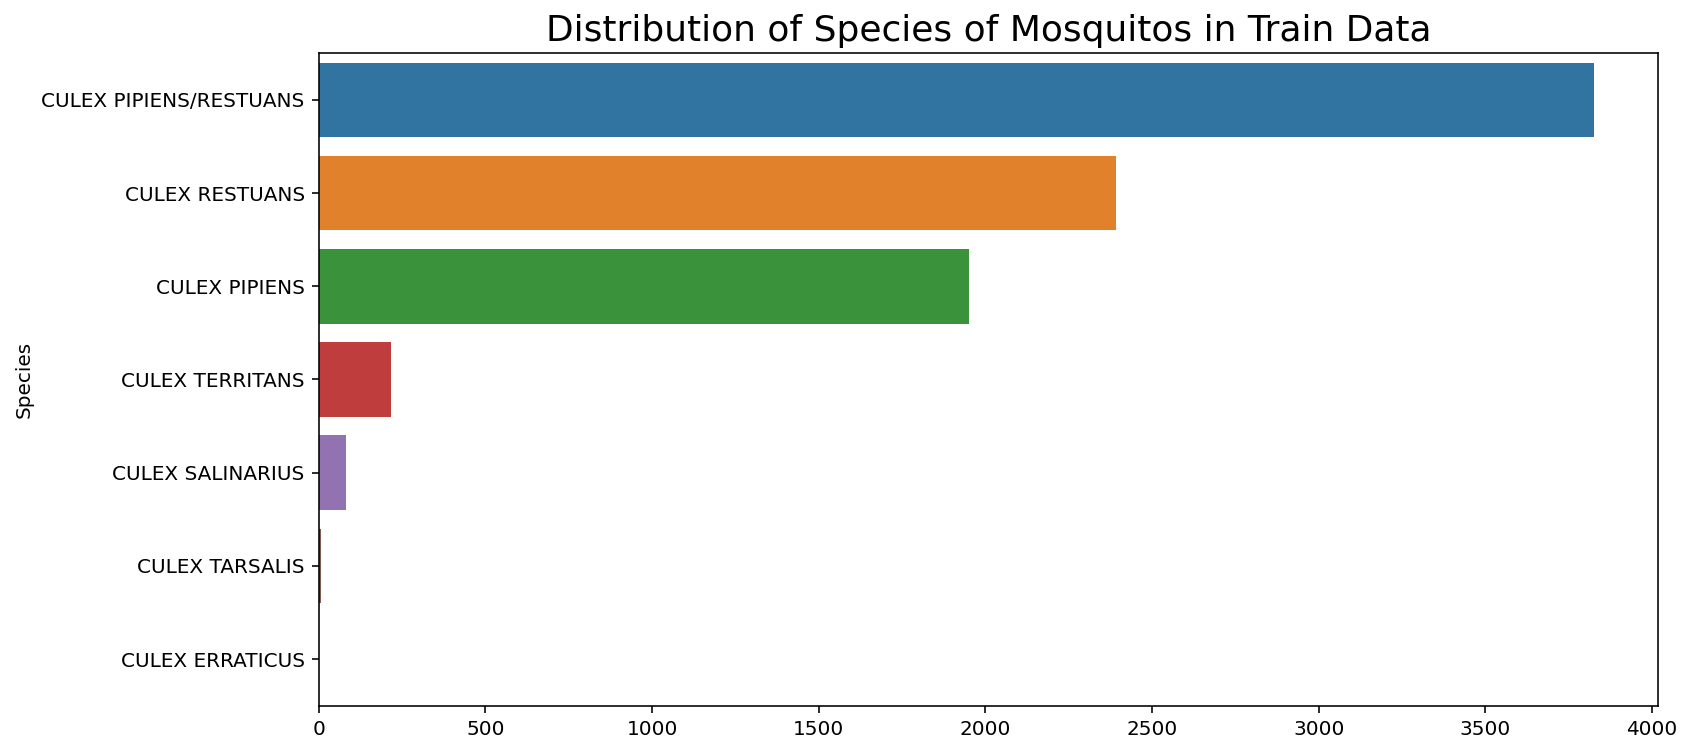

In [22]:
# Plot distribution of mosquito species
plt.figure(figsize=(12,6))
plt.title('Distribution of Species of Mosquitos in Train Data',fontsize=18)
sns.barplot(data=train,
            x=train.value_counts('Species').values,
            y=train.value_counts('Species').index,
            orient='h');

Observations:
- Total of 6 different species present in the data.
- Most common species are Culex Restuans and Culex Pipiens.

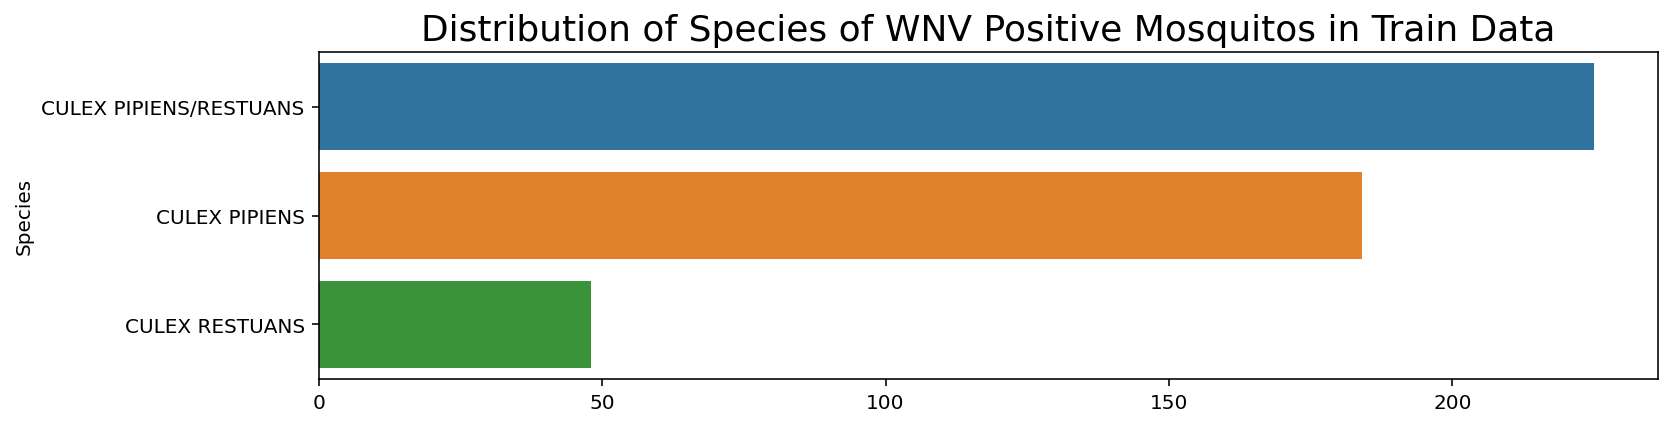

In [23]:
wnv_present = train[train['WnvPresent'] == 1]

plt.figure(figsize=(12,3))
plt.title('Distribution of Species of WNV Positive Mosquitos in Train Data',fontsize=18)
sns.barplot(data=wnv_present,
            x=wnv_present.value_counts('Species').values,
            y=wnv_present.value_counts('Species').index,
            orient='h')

plt.savefig('../assets/species_dist.png');

Observations:
- Presence of WNV is only detected on 2 of the mosquito species, Culex Pipiens and Culex Restuans.
- Species can be a useful indicator in the model prediction on presence of WNV.
- However, due to the low population of the other mosquito species, this may not necessarily indicate that the presence of the virus is only detected in Culux Pipiens and Culex Restuans.

## 4. WNV/Mosquito Seasonality <a class="anchor" id="chapter4"></a>
---
This section will explore if there are seasonalities with regards to the WNV and mosquito numbers.

In [24]:
# Create columns to store month, year, and year-month data to identify seasonalities
train['day'] = pd.DatetimeIndex(train['Date']).day
train['month'] = pd.DatetimeIndex(train['Date']).month
train['year'] = pd.DatetimeIndex(train['Date']).year
train['year_month'] = train['year'].astype('string')+'-'+train['month'].astype('string')

# Create same columns for test set
test['day'] = pd.DatetimeIndex(test['Date']).day
test['month'] = pd.DatetimeIndex(test['Date']).month
test['year'] = pd.DatetimeIndex(test['Date']).year
test['year_month'] = test['year'].astype('string')+'-'+test['month'].astype('string')

In [25]:
# Observing seasonalities in the months
seasonal_train = train.groupby('year_month').sum()[['NumMosquitos','WnvPresent']]
# Converting index to datetime object
seasonal_train.index = pd.to_datetime(seasonal_train.index)
# Sorting time values in index
seasonal_train.sort_index(inplace=True)

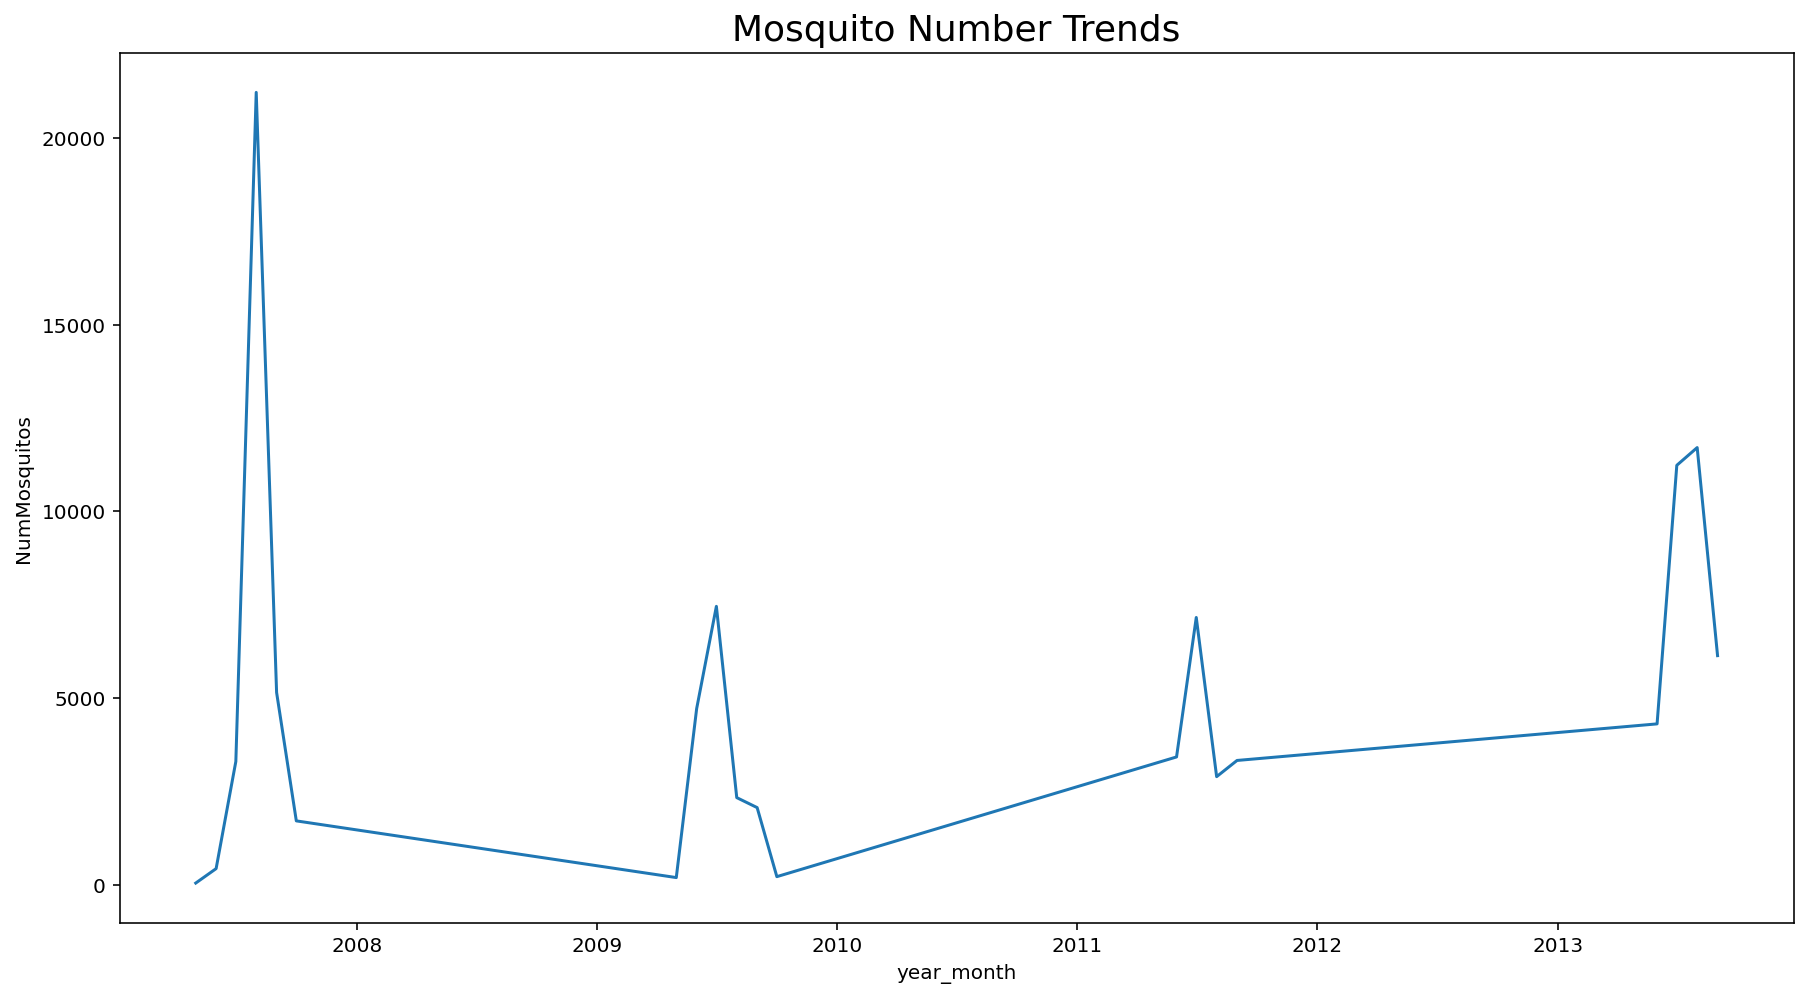

In [26]:
# Plot number of mosquitos in traps over duration of data
plt.figure(figsize=(15,8))
plt.title('Mosquito Number Trends', fontsize=18)
sns.lineplot(data=seasonal_train['NumMosquitos']);

Observations:
- Given that the data in train only spans 2007, 2009, 2011, 2013, there are clear trends in the spike of number of mosquitos which happen sometime in Aug of each year.
- However, given that the traps are only collected from May to Oct each year, it is inconclusive to suggest that Aug is the only month with a spike in number of mosquitos.
- Further exploration is required to understand what causes this seasonality behavior.

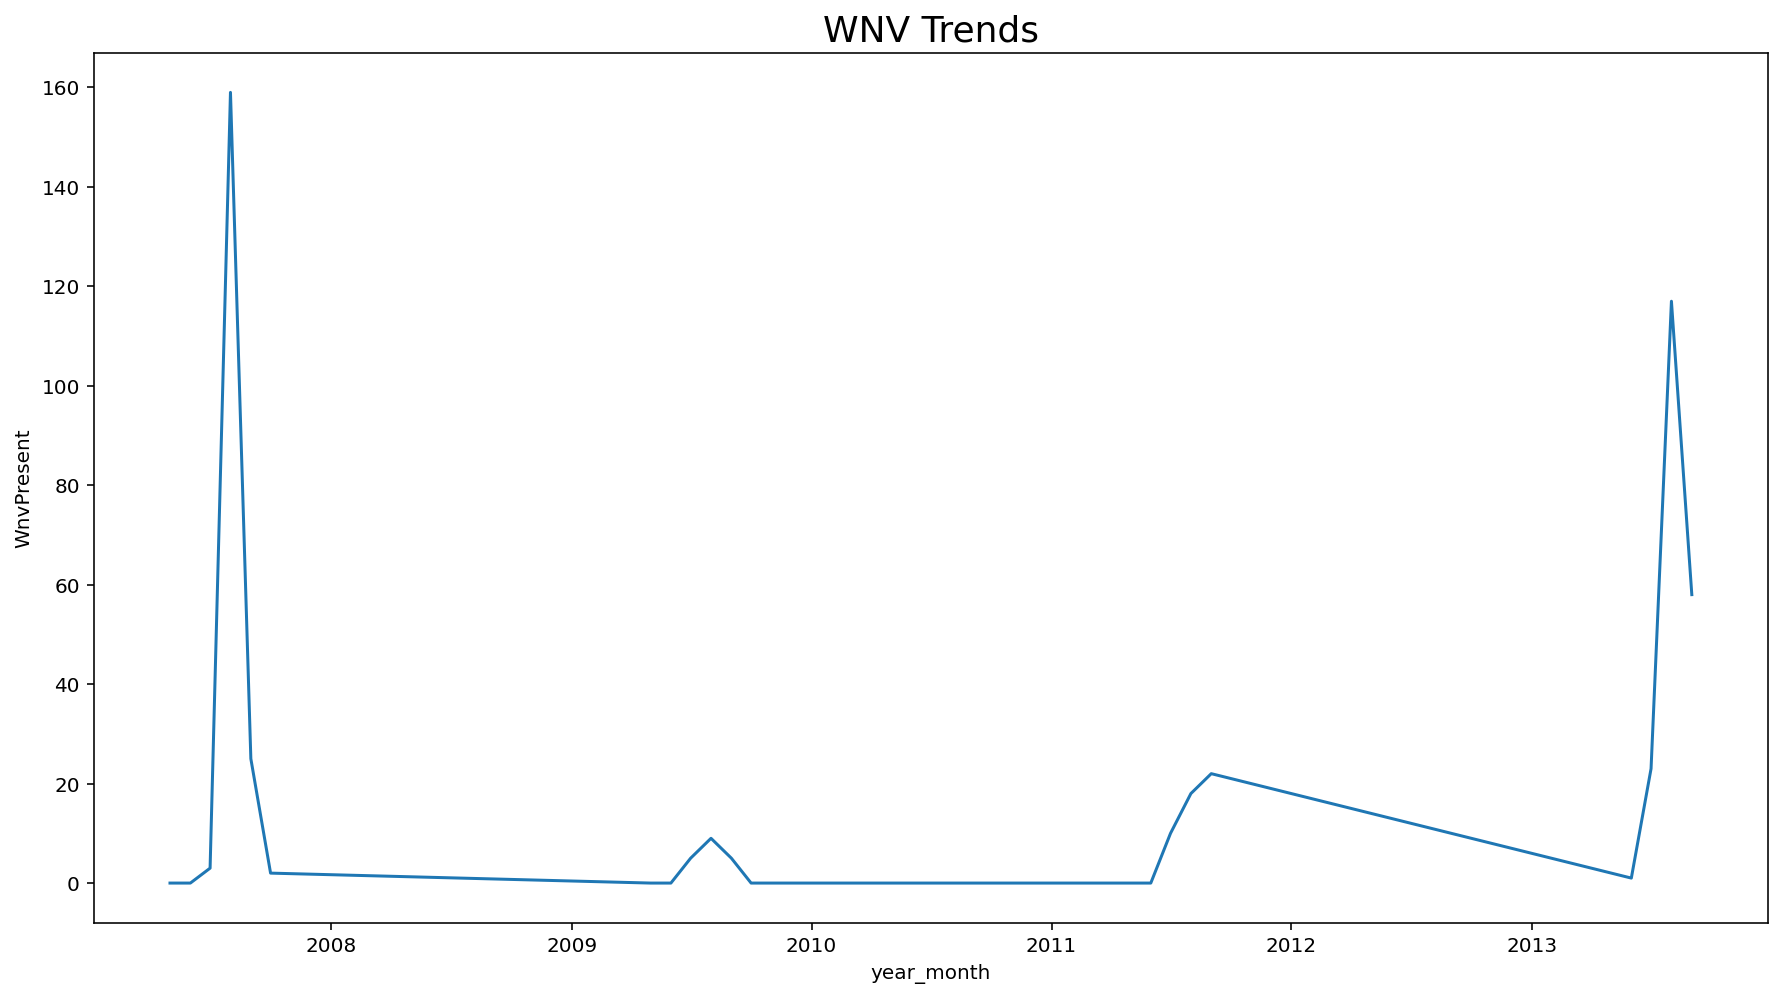

In [27]:
# Plot trend of WNV presence
plt.figure(figsize=(15,8))
plt.title('WNV Trends', fontsize=18)
sns.lineplot(data=seasonal_train['WnvPresent']);

Observations:
- Similar to the number of mosquitos, the presence of WNV follows a similar trend of spiking in Aug.
- This is expected as when the number of mosquitos increases, the chances of detecting WNV also increases.

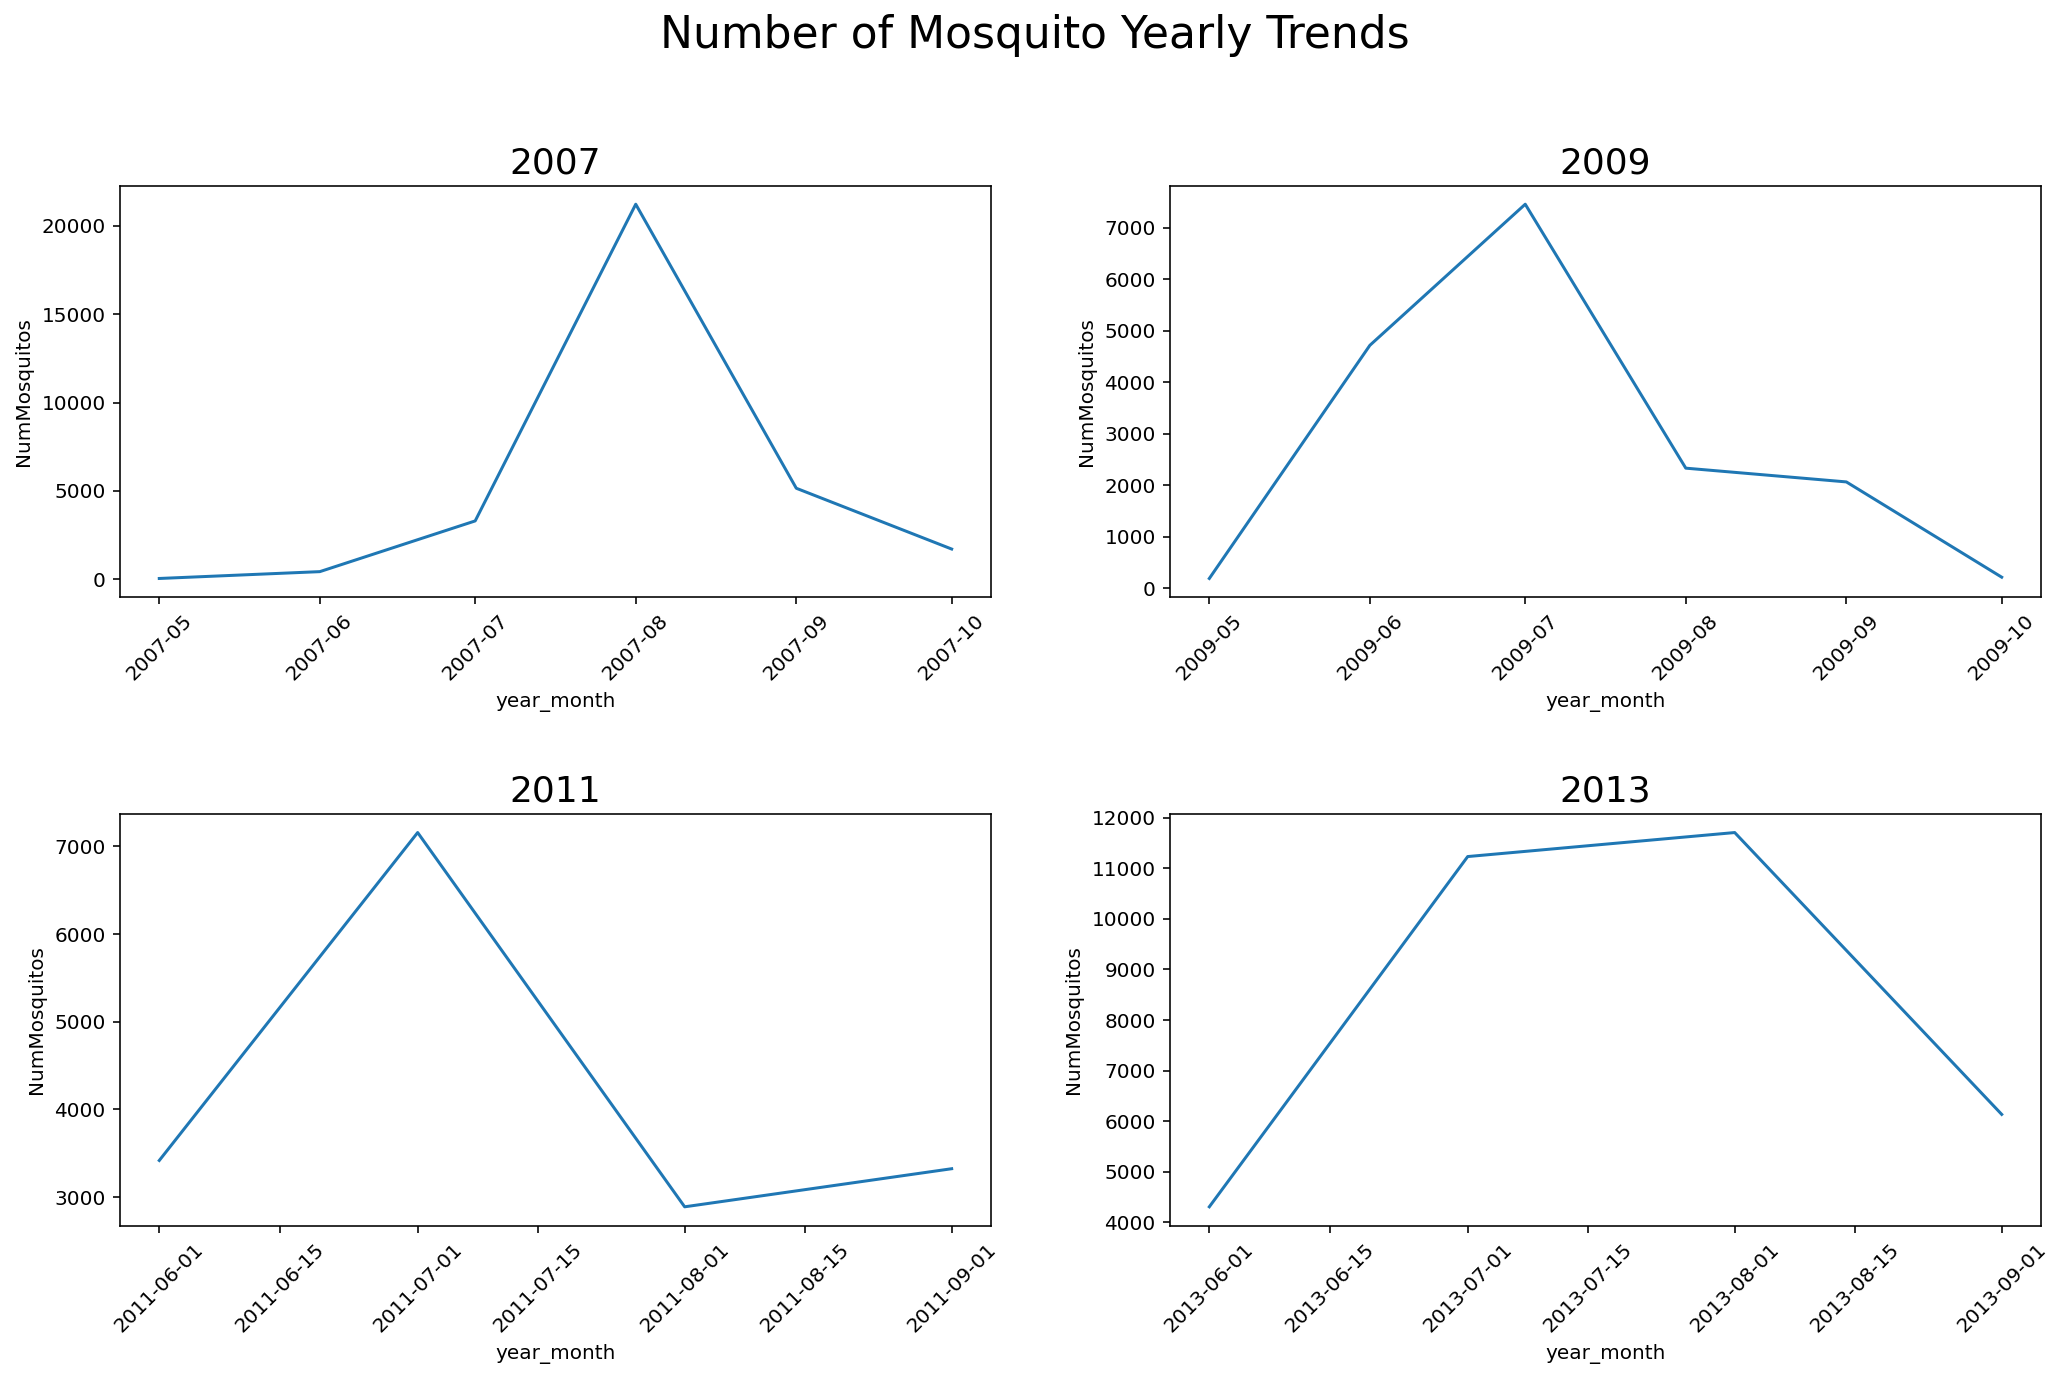

In [28]:
seasonal_07 = seasonal_train.loc['2007-05-01':'2007-12-01']
seasonal_09 = seasonal_train.loc['2009-05-01':'2009-12-01']
seasonal_11 = seasonal_train.loc['2011-05-01':'2011-12-01']
seasonal_13 = seasonal_train.loc['2013-05-01':'2013-12-01']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.suptitle('Number of Mosquito Yearly Trends', fontsize=22)

sns.lineplot(data=seasonal_07['NumMosquitos'], ax=ax[0][0])
ax[0][0].set_title('2007', fontsize=18)
ax[0][0].tick_params('x', labelrotation=45)

sns.lineplot(data=seasonal_09['NumMosquitos'], ax=ax[0][1])
ax[0][1].set_title('2009', fontsize=18)
ax[0][1].tick_params('x', labelrotation=45)

sns.lineplot(data=seasonal_11['NumMosquitos'], ax=ax[1][0])
ax[1][0].set_title('2011', fontsize=18)
ax[1][0].tick_params('x', labelrotation=45)

sns.lineplot(data=seasonal_13['NumMosquitos'], ax=ax[1][1])
ax[1][1].set_title('2013', fontsize=18)
ax[1][1].tick_params('x', labelrotation=45)

fig.tight_layout(pad=3);


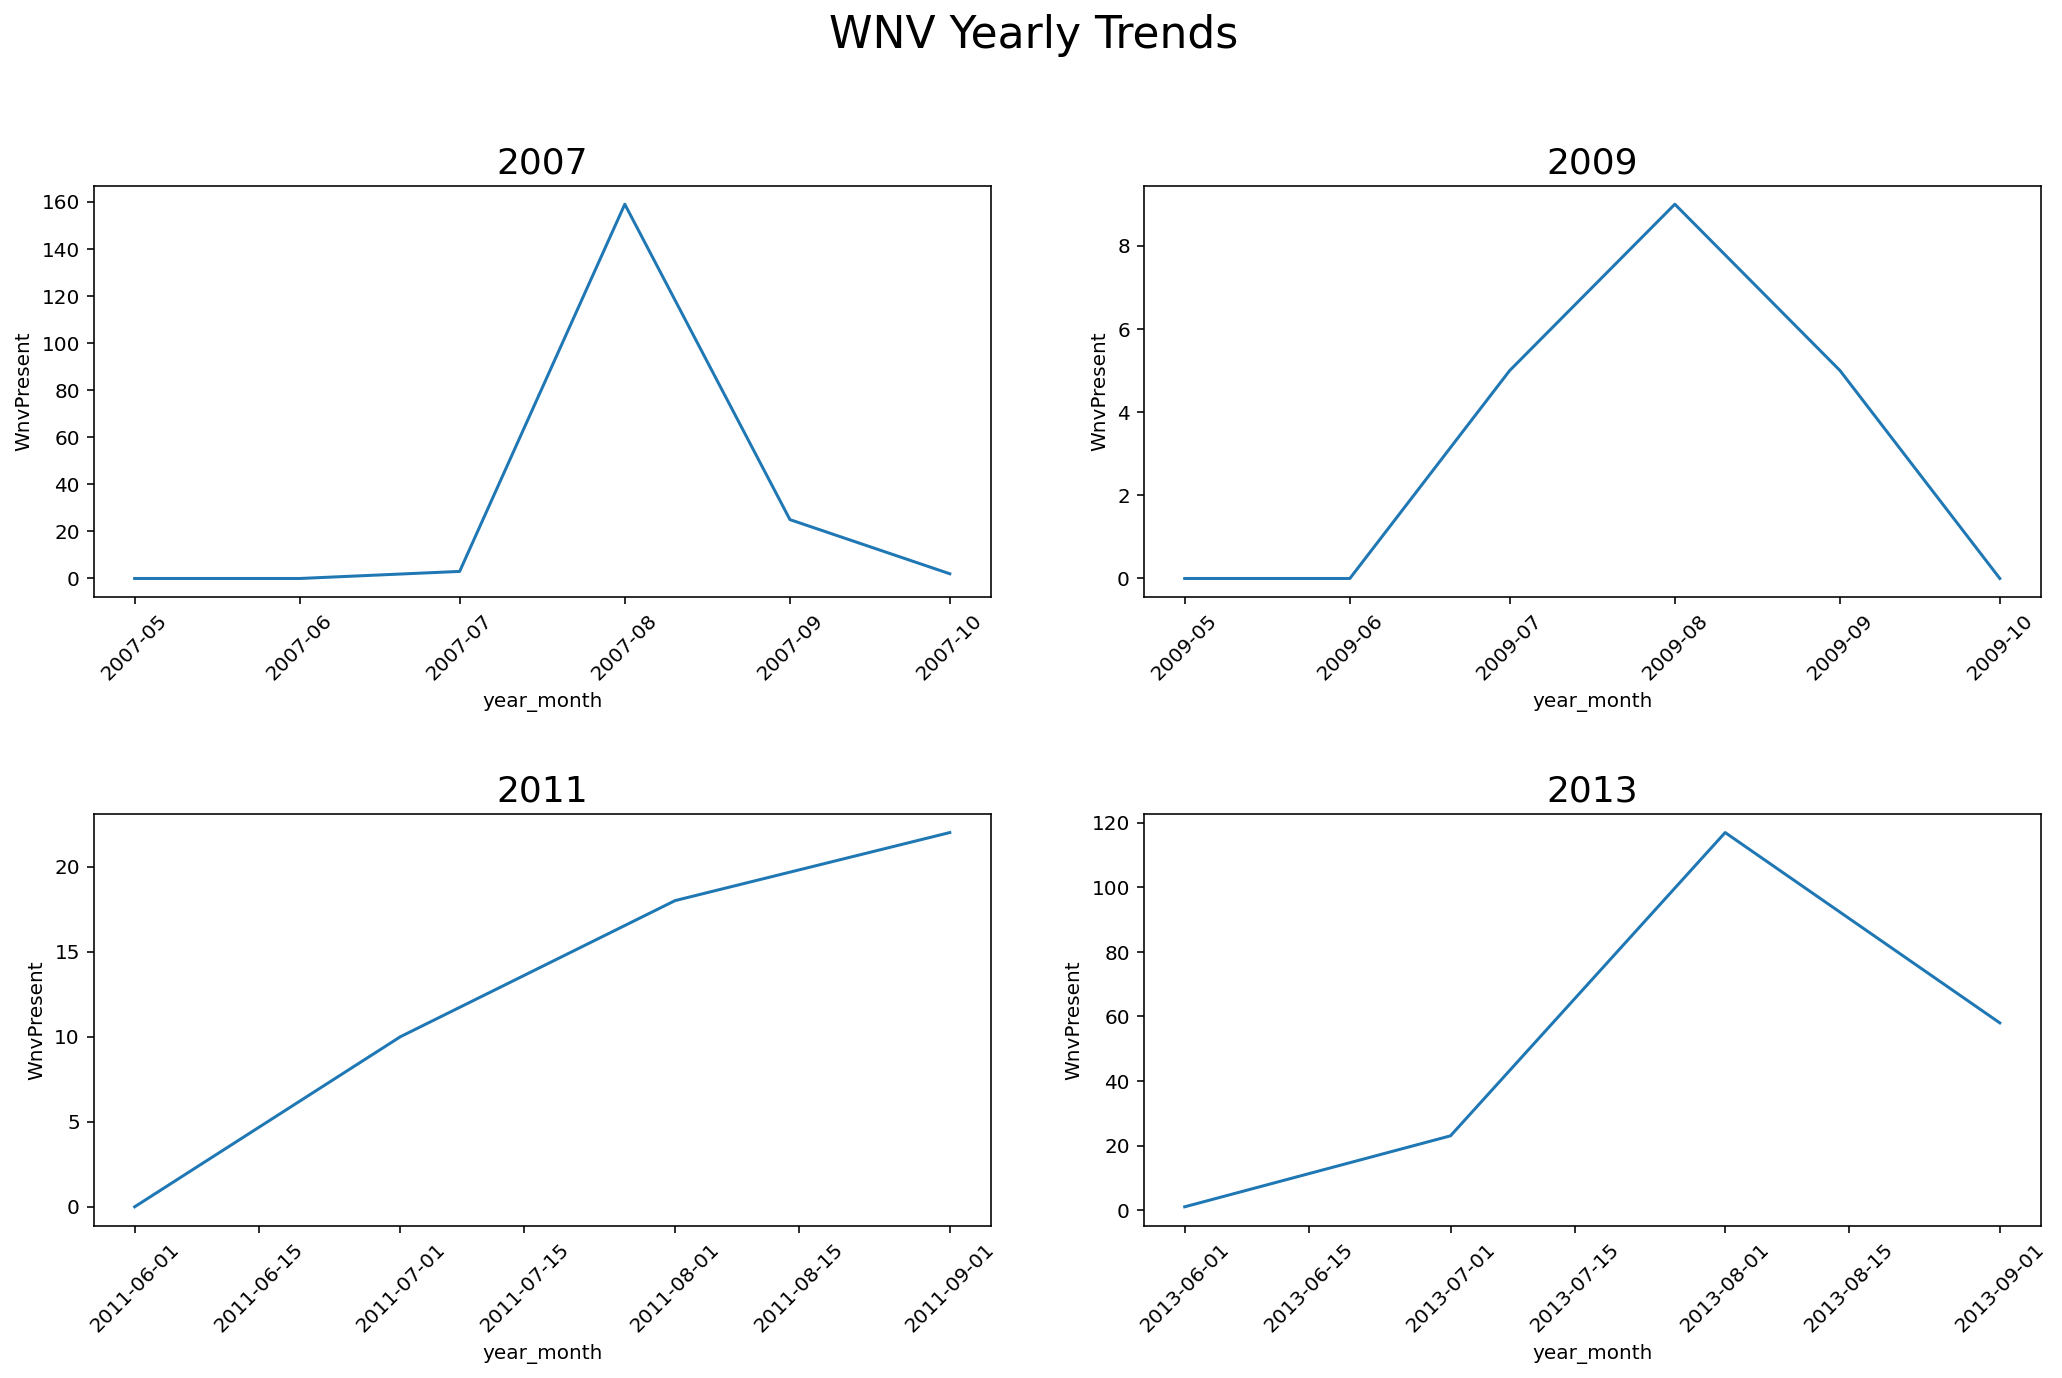

In [29]:
seasonal_07 = seasonal_train.loc['2007-05-01':'2007-12-01']
seasonal_09 = seasonal_train.loc['2009-05-01':'2009-12-01']
seasonal_11 = seasonal_train.loc['2011-05-01':'2011-12-01']
seasonal_13 = seasonal_train.loc['2013-05-01':'2013-12-01']

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.suptitle('WNV Yearly Trends', fontsize=22)

sns.lineplot(data=seasonal_07['WnvPresent'], ax=ax[0][0])
ax[0][0].set_title('2007', fontsize=18)
ax[0][0].tick_params('x', labelrotation=45)

sns.lineplot(data=seasonal_09['WnvPresent'], ax=ax[0][1])
ax[0][1].set_title('2009', fontsize=18)
ax[0][1].tick_params('x', labelrotation=45)

sns.lineplot(data=seasonal_11['WnvPresent'], ax=ax[1][0])
ax[1][0].set_title('2011', fontsize=18)
ax[1][0].tick_params('x', labelrotation=45)

sns.lineplot(data=seasonal_13['WnvPresent'], ax=ax[1][1])
ax[1][1].set_title('2013', fontsize=18)
ax[1][1].tick_params('x', labelrotation=45)

fig.tight_layout(pad=3);


Observations:
- Looking further into the yearly trends, if is observed that the presence of WNV follows the trend of number of mosquitos closely.
- This is expected as the higher the number of mosquitos, the higher the chance of detecting WNV.

## 5. Traps/Mosquitos Distribution <a class="anchor" id="chapter5"></a>
---
This section will explore the distribution of the number of mosquitos caught in traps.

In [30]:
data=train.groupby('Trap').sum()

In [31]:
data.mean()

Block                2427.176471
Latitude             2607.596590
Longitude           -5464.803896
AddressAccuracy       494.867647
NumMosquitos          727.727941
WnvPresent              3.360294
spray_14                5.691176
Tavg                 4478.796218
PrecipTotal             8.817237
DewPoint             3660.555672
R_Humid              3961.349142
day                   965.029412
month                 479.867647
year               125237.639706
dtype: float64

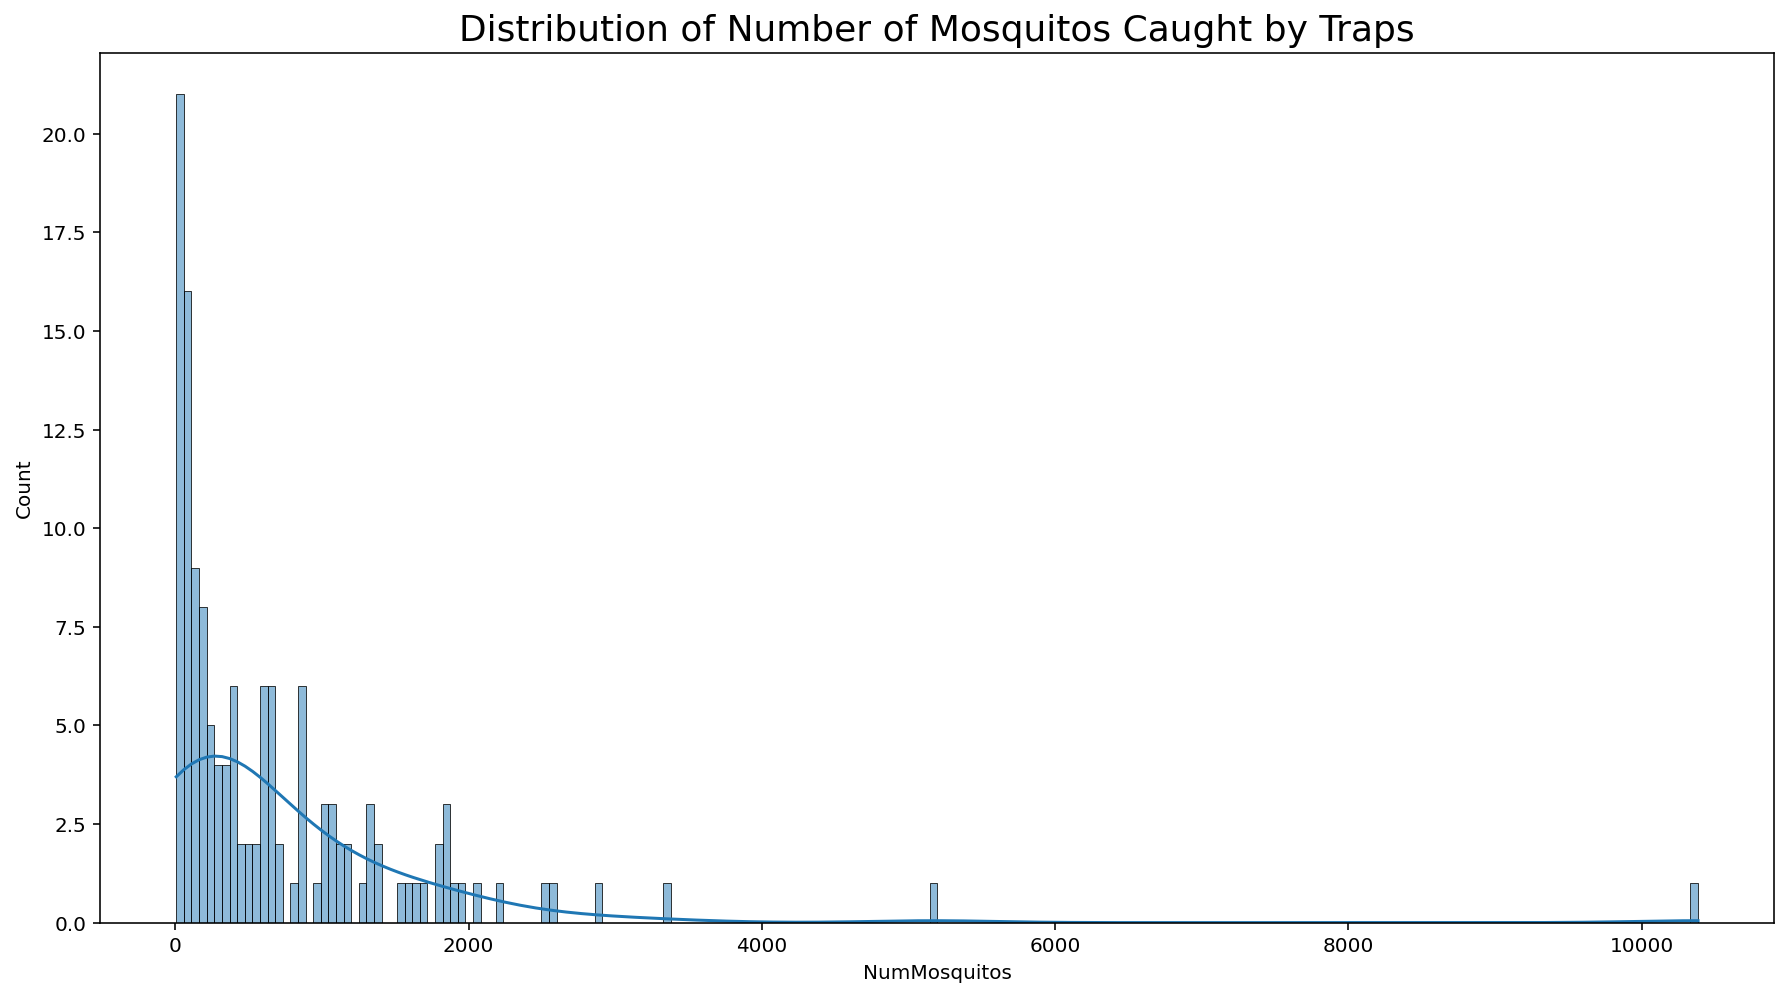

In [32]:
# Plotting the number of mosquitos caught in various traps
plt.figure(figsize=(15,8))
plt.title('Distribution of Number of Mosquitos Caught by Traps', fontsize=18)
sns.histplot(data=train.groupby('Trap').sum(),x='NumMosquitos',bins=200, kde=True);

Observations:
- Average number of mosquitos caught per trab is about 700.
- Some traps have an extremely high count of more than 10,000.
- This could be due to uneven sampling of the traps.

In [33]:
# Looking at the trap counts
print(train.value_counts('Trap').sort_values(ascending=False))

Trap
T900     154
T002     147
T135     147
T115     143
T151     143
        ... 
T078       6
T094B      5
T076       5
T237       3
T040       2
Length: 136, dtype: int64


As some traps are more heavily sampled compared to others, we will instead look at average number of mosquitos caught per trap, instead of the total number of mosquitos caughts.

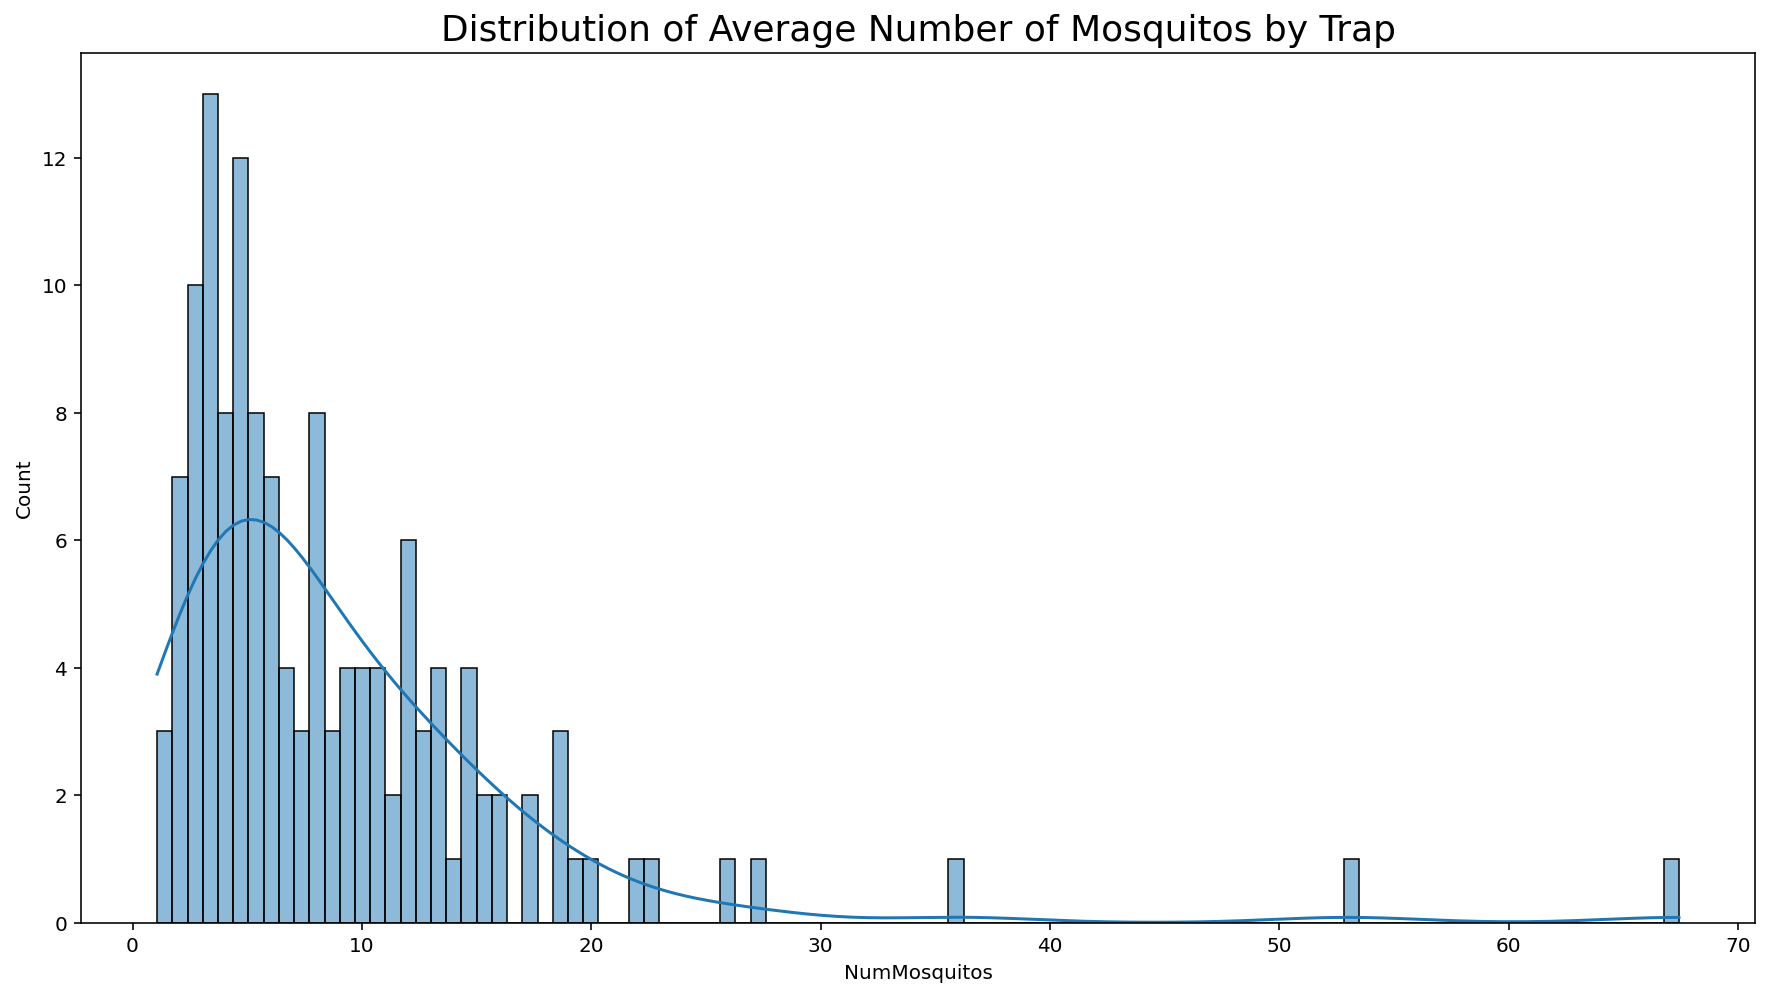

In [34]:
# Obtaining mean of number of mosquitos caught by trap
data = train.pivot_table(values=['NumMosquitos'],index=['Trap'],aggfunc='mean')

# Plot distribution of average number of mosquitos
plt.figure(figsize=(15,8))
plt.title('Distribution of Average Number of Mosquitos by Trap', fontsize=18)
sns.histplot(data=data, x='NumMosquitos', bins=100, kde=True);

In [35]:
# Display top 10 traps with average number of mosquitos
display(data.sort_values(by='NumMosquitos',ascending=False).head(10))

,NumMosquitos
Trap,
T900,67.428571
T103,52.968750
T115,36.139860
T086,27.139535
T138,25.821705
T008,22.451327
T225,22.190476
T002,19.687075
T903,19.010417


In [36]:
# Printing address and coordinates of top 5 locations
top_5 = list(data.sort_values(by='NumMosquitos',ascending=False).head(5).index)

for trap in top_5:
    print(f"Address: {train[train['Trap']==trap].iloc[0]['Address']}")
    print(f"Coordinates: {train[train['Trap']==trap].iloc[0]['coord']}\n")

Address: ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA
Coordinates: (41.974689, -87.890615)

Address: South Avenue L, Chicago, IL 60617, USA
Coordinates: (41.702723999999996, -87.536497)

Address: South Doty Avenue, Chicago, IL, USA
Coordinates: (41.673408, -87.599862)

Address: 2200 West 113th Street, Chicago, IL 60643, USA
Coordinates: (41.688324, -87.676709)

Address: South Stony Island Avenue, Chicago, IL, USA
Coordinates: (41.726465000000005, -87.585413)



Observations:
- Location with the highest average number of mosquitos is at the international airport. However, this could be due to the trap being sampled a lot more frequently, which might give rise to more sampling during periods where the mosquito count is high. 
- Areas sampled heavily are mainly in the South

## 6. Weather Trends <a class="anchor" id="chapter6"></a>
---
We earlier detected trends in terms of the number of mosquitos and the presence of WNV across the months sampled (May to October). Both the number of mosquitos and the presence of the virus peaks sometime in Jul to Aug, months where the weather is hotter and wetter. This section explores the effect of weather on the number of mosquitos and the presence of WNV.

<img src="../assets/temperature_ch.png" style="width: 500px;"/>
<img src="../assets/precipitation_ch.png" style="width: 500px;"/>

From the [weather data](https://www.isws.illinois.edu/statecli/general/chicago-climate-narrative.htm#:~:text=Chicago's%20climate%20is%20typically%20continental,to%20be%20the%20most%20pleasant), it is observed that temperature peaks to the highest in Jul and Aug, and precipitation also peaks in Aug. This suggest that both heat and moisture provide good weather conditions for the growth of mosquitos and consequently the presence of WNV.

In [37]:
# Creating dataframe to explore weather conditions against numner of mosquitos and WNV
humid_wnv = train.pivot_table(index='Date',
                              values=['R_Humid','WnvPresent', 'Tavg', 'NumMosquitos', 'PrecipTotal'],
                              aggfunc={
                                  'R_Humid':'mean', # To get mean of humidity
                                  'WnvPresent':'sum', # Sum of the number of rows with WNV present
                                  'Tavg':'mean', # Mean of the average temperature
                                  'NumMosquitos':'sum', # Sum of the number of mosquitos
                                  'PrecipTotal':'mean' # Mean of the precipitation
                              })

humid_wnv['PrecipTotal'] = humid_wnv['PrecipTotal']*100 # Scaling precipitation values to observe trend better
humid_wnv['NumMosquitos'] = humid_wnv['NumMosquitos']/50 # Scaling number of mosquitos to get trend better

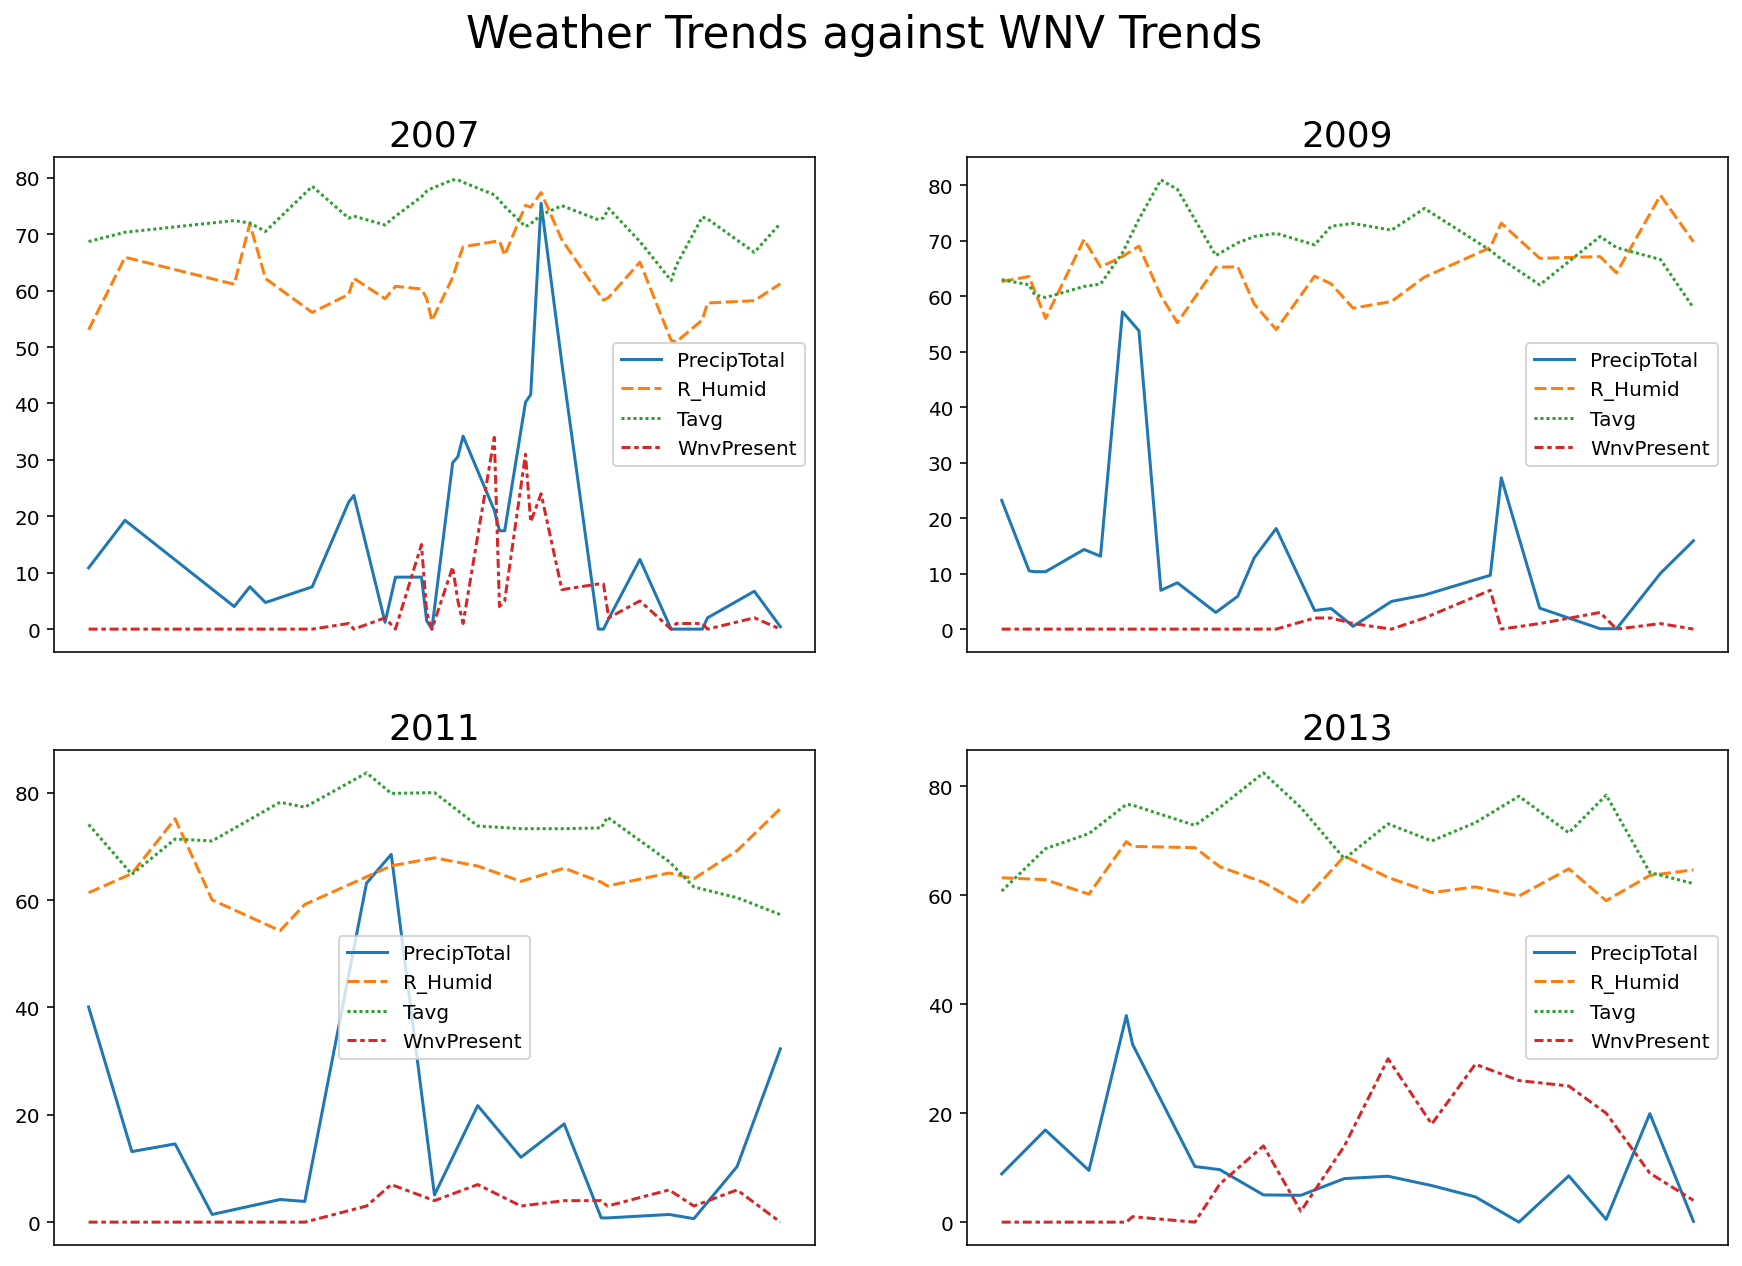

In [38]:
# Creating date extracts from main data
humid_wnv_07 = humid_wnv.loc['2007-05-01':'2007-10-31']
humid_wnv_09 = humid_wnv.loc['2009-05-01':'2009-10-31']
humid_wnv_11 = humid_wnv.loc['2011-05-01':'2011-10-31']
humid_wnv_13 = humid_wnv.loc['2013-05-01':'2013-10-31']

# Subplots for the 4 different years for trends against weather conditions and WNV presence
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.suptitle('Weather Trends against WNV Trends', fontsize=22)

sns.lineplot(data=humid_wnv_07.drop('NumMosquitos',axis=1), ax=ax[0][0])
ax[0][0].set_title('2007', fontsize=18)
ax[0][0].get_xaxis().set_visible(False)

sns.lineplot(data=humid_wnv_09.drop('NumMosquitos',axis=1), ax=ax[0][1])
ax[0][1].set_title('2009', fontsize=18)
ax[0][1].get_xaxis().set_visible(False)

sns.lineplot(data=humid_wnv_11.drop('NumMosquitos',axis=1), ax=ax[1][0])
ax[1][0].set_title('2011', fontsize=18)
ax[1][0].get_xaxis().set_visible(False)

sns.lineplot(data=humid_wnv_13.drop('NumMosquitos',axis=1), ax=ax[1][1])
ax[1][1].set_title('2013', fontsize=18)
ax[1][1].get_xaxis().set_visible(False);

Observations:
- Trends of the virus seem to follow precipitation trends in 2007 quite well, however, does not occur in the other years (behaves inversely in 2013).
- Weather tends to peak in about Aug, suggesting strong correlation between temperature and the presence of the virus.
- No observable trends between relative humidity and presence of the virus.

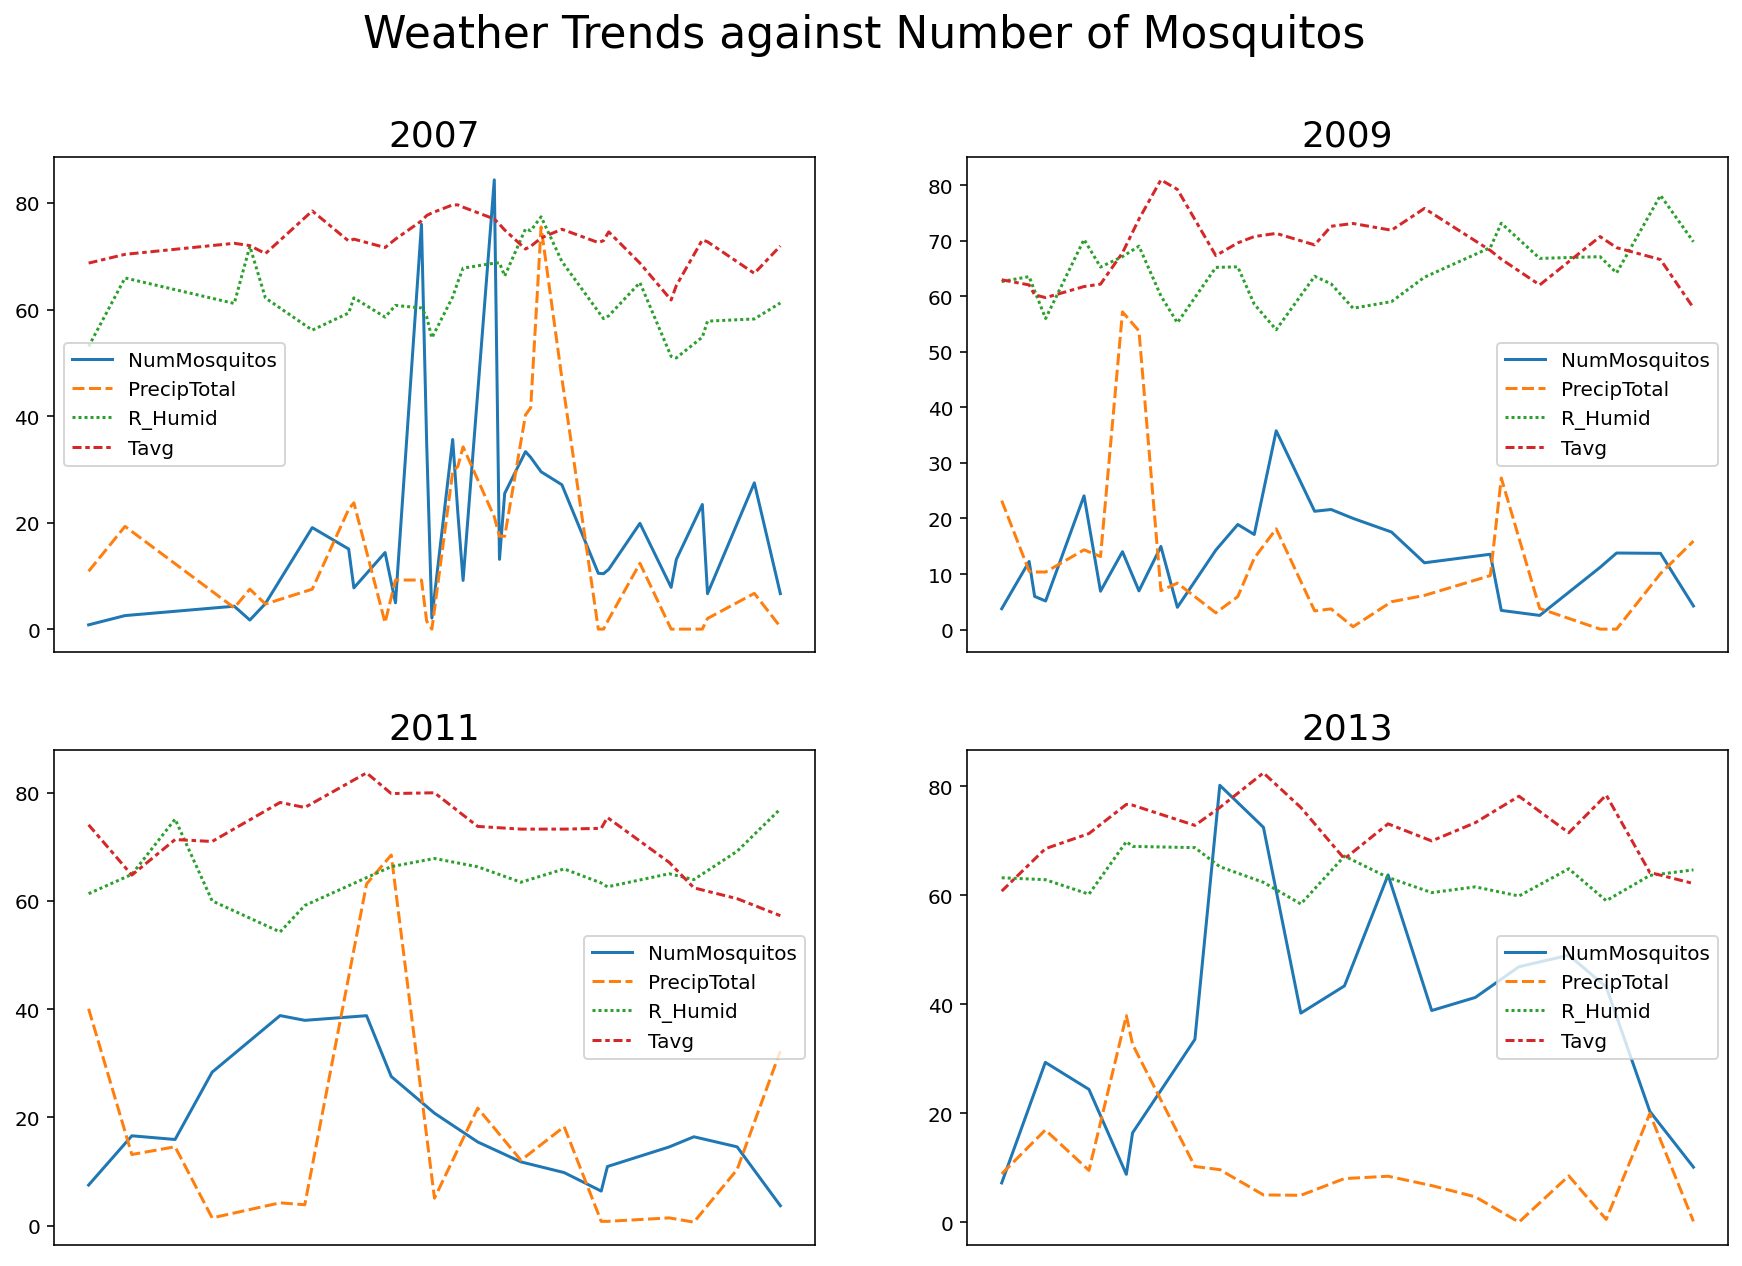

In [40]:
# Plot trends of number of mosquitos caught in traps
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.suptitle('Weather Trends against Number of Mosquitos', fontsize=22)

sns.lineplot(data=humid_wnv_07.drop('WnvPresent',axis=1), ax=ax[0][0])
ax[0][0].set_title('2007', fontsize=18)
ax[0][0].get_xaxis().set_visible(False)

sns.lineplot(data=humid_wnv_09.drop('WnvPresent',axis=1), ax=ax[0][1])
ax[0][1].set_title('2009', fontsize=18)
ax[0][1].get_xaxis().set_visible(False)

sns.lineplot(data=humid_wnv_11.drop('WnvPresent',axis=1), ax=ax[1][0])
ax[1][0].set_title('2011', fontsize=18)
ax[1][0].get_xaxis().set_visible(False)

sns.lineplot(data=humid_wnv_13.drop('WnvPresent',axis=1), ax=ax[1][1])
ax[1][1].set_title('2013', fontsize=18)
ax[1][1].get_xaxis().set_visible(False)

plt.savefig('../assets/weather_trends.png');


Observations:
- Precipitation seems to have strong correlation with number of mosquitos in 2007 and 2009, but no observable trends in the other years.
- Temperature peaks in Aug, which conincides with the peak in the number of mosquitos.
- Relative humidity stays relatively constant through the months of May to Oct, with no observable trends with the number of mosquitos.

## 7. Spray Analysis <a class="anchor" id="chapter7"></a>
---
Mosquito sprays were also conducted to prevent the spread of WNV. The sprays kill off larvae that have hatched and adult mosquitos. In the [previous notebook](./01_data_processing.ipynb), we engineered a feature to mark datapoints that have had a spray within a 5 mile radius within the last 14 days. Further exploration into the effectiveness of the sprays will be explored here.

In [41]:
spray_traps = list(train[train['spray_14']==1]['Trap'].unique()) # Creating list of traps that have been marked by spray marker
spray_extract = train[train['Trap'].isin(spray_traps)] # Extracting data for comparing effect of sprays

# Pivoting to identify the effect of spray on number of mosquitos and presence of the virus
spray_details = spray_extract.pivot_table(values=['NumMosquitos','WnvPresent','Trap'],
                                          index=['spray_14','year'],
                                          aggfunc={
                                              'NumMosquitos':'sum',
                                              'WnvPresent':'sum',
                                              'Trap':'count'
                                          })

# Creating features for details per trap
spray_details['MosPTrap'] = spray_details['NumMosquitos']/spray_details['Trap']
spray_details['WnvPTrap'] = spray_details['WnvPresent']/spray_details['Trap']

display(spray_details)

NumMosquitos  Trap  WnvPresent   MosPTrap  WnvPTrap
spray_14 year                                                     
0        2007         20936  1505         119  13.910963  0.079070
         2009         15713  1715          18   9.162099  0.010496
         2011         15540  1619          44   9.598518  0.027177
         2013         19194  1297          76  14.798766  0.058597
1        2011           575    59           5   9.745763  0.084746
         2013         14185   715         123  19.839161  0.172028

Observations:
- No significant impact observed of the spray on the number of mosquitos.
- No significant impact on the presence of WNV for the same trap that has been sprayed.

In [42]:
# Obtaining unique dates for sprays
print(train[train['spray_14']==1]['Date'].unique())

['2011-09-12T00:00:00.000000000' '2011-09-16T00:00:00.000000000'
 '2013-07-19T00:00:00.000000000' '2013-07-25T00:00:00.000000000'
 '2013-08-01T00:00:00.000000000' '2013-08-08T00:00:00.000000000'
 '2013-08-15T00:00:00.000000000' '2013-08-22T00:00:00.000000000'
 '2013-08-29T00:00:00.000000000' '2013-09-06T00:00:00.000000000'
 '2013-09-12T00:00:00.000000000' '2013-09-19T00:00:00.000000000']


Looking further into the data, we note that the sprays have only been conducted on a total of 12 different days. Due to the limited data, no results can be drawn from the analysis on the impact of sprays. Recommend to further collect more data to evaluate effect of sprays.

## 8. Location Analysis <a class="anchor" id="chapter8"></a>
---
As the datapoints include coordinates of the different traps and mosquitos generally have a flight radius of about 3 miles, an area detected to have the virus may lead to the spread of the virus in nearby regions. 

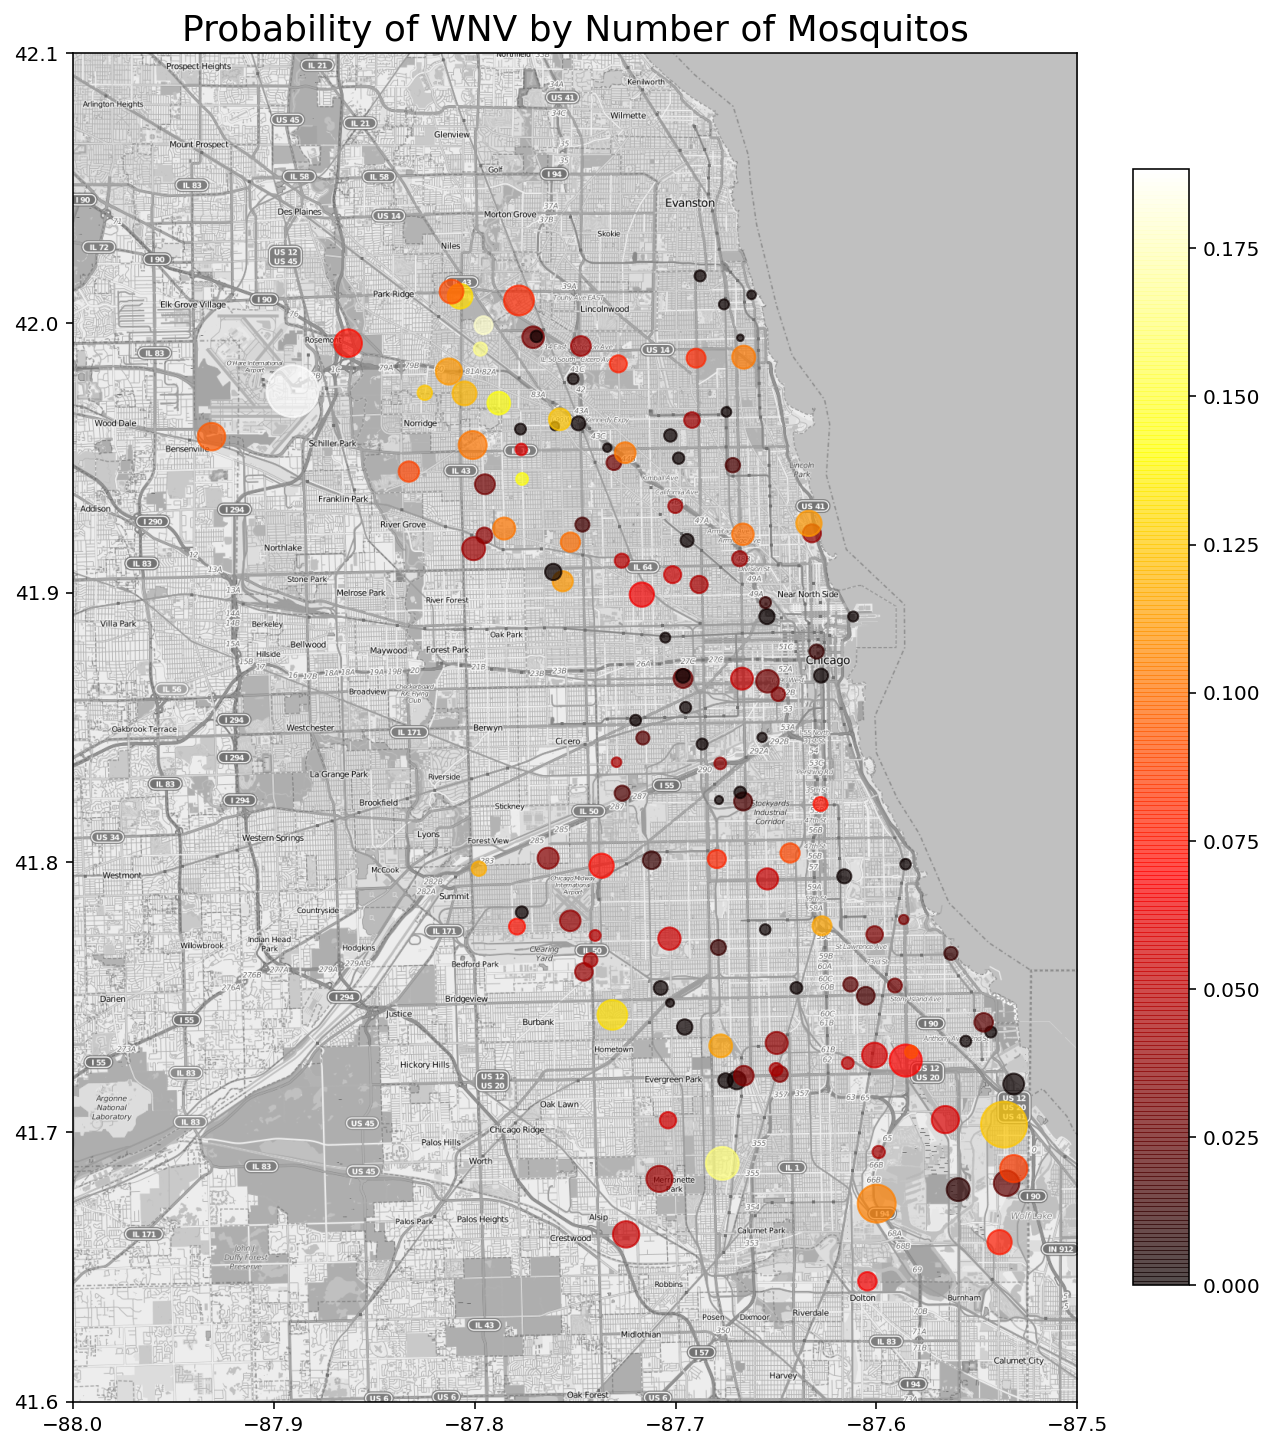

In [44]:
# Creating map data
mapdata = np.loadtxt('../data/mapdata_copyright_openstreetmap_contributors.txt')
# Getting all the coordinates within train data
train_loc = train.groupby(['Latitude', 'Longitude'],as_index=False).mean().copy()
# Isolating details required to plot ma[]
traps = train[['Date', 'Trap','Longitude', 'Latitude', 'WnvPresent']]

# Defining mapplot
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata,
          cmap=plt.get_cmap('gray'),
          extent=lon_lat_box,
          aspect=aspect)

# Get all unique coordinates
locations = traps[['Longitude', 'Latitude']].drop_duplicates().values
# Scatter plot based on presence of virus and size of marker indicating number of mosquitos
plt.scatter(train_loc['Longitude'], train_loc['Latitude'], c=train_loc.WnvPresent, s=10*train_loc.NumMosquitos, 
            marker='o',alpha=0.7, cmap='hot')
plt.colorbar(fraction=0.05)
plt.title('Probability of WNV by Number of Mosquitos', fontsize=18)

plt.savefig('../assets/map_plot.png');

Observations:
- Size of the dots represent the number of mosquitos. Bigger dots seem to tend to be clustered together. However, this could also be due to the uneven sampling of traps as earlier observed.
- Presence of the virus is indicated in lighter colors. Generally, the lighter dots seems to be clustered together, suggesting clusters of the virus.
- However, it is also observed that the smaller dots generally tend to be darker while the lighter dots tend to be bigger. This again is due to a higher probability of detecting the virus when traps catch a higher number of mosquitos. 

From these observations, we will engineer a feature to assign a weight to the distance from the point of the trap to the nearest coordinate that has the virus in that respective year.

In [70]:
# Overwrite coordinate to create tuple of Latitude and Longitude
train['coord'] = list(zip(train.Latitude, train.Longitude))

# Isolating coordinates with WNV present in respective years of train data
wnv_locs = train[train['WnvPresent']==1].set_index('Date')
wnv_locs_07 = list(wnv_locs.loc['2007-01-01':'2007-12-31']['coord'].unique())
wnv_locs_09 = list(wnv_locs.loc['2009-01-01':'2009-12-31']['coord'].unique())
wnv_locs_11 = list(wnv_locs.loc['2011-01-01':'2011-12-31']['coord'].unique())
wnv_locs_13 = list(wnv_locs.loc['2013-01-01':'2013-12-31']['coord'].unique())

In [71]:
# Create location weight function
def dist_calculator(data, location):
    x1, y1 = location # Unpack coordiate of datapoint
    
    nearest_dist = 100000000 # Set arbitrary high number
    for coord in data: # Loop through all coordinates with presence of WNV in that year
        x2, y2 = coord # Unpack coordinate
        dist = ((x2 - x1)**2 + (y2-y1)**2)**0.5 # Calculate vector distance
        if dist < nearest_dist: # Return minimum distance
            nearest_dist = dist
    return 1 - nearest_dist # The closer the point, the higher the weight assigned

In [72]:
train_07 = train[train['year']==2007].copy()
train_09 = train[train['year']==2009].copy()
train_11 = train[train['year']==2011].copy()
train_13 = train[train['year']==2013].copy()

train_07['dist_marker'] = train_07['coord'].map(lambda x: dist_calculator(wnv_locs_07, x))
train_09['dist_marker'] = train_09['coord'].map(lambda x: dist_calculator(wnv_locs_09, x))
train_11['dist_marker'] = train_11['coord'].map(lambda x: dist_calculator(wnv_locs_11, x))
train_13['dist_marker'] = train_13['coord'].map(lambda x: dist_calculator(wnv_locs_13, x))

train = pd.concat([train_07,train_09,train_11,train_13])

In [73]:
print(train['dist_marker'].value_counts())

1.000000    4684
0.970632      82
0.987286      77
0.973543      74
0.958822      68
            ... 
0.973668       5
0.996083       5
0.964452       3
0.992497       2
0.971336       1
Name: dist_marker, Length: 147, dtype: int64


The marker assigns a weight if the location has detected presence of the virus within the year. However, in our earlier analysis, we also understand that mosquitos and the virus follow a seasonality through the months. As such, we will assign a weight based on the months in order to factorize the dist_marker.

|Month|Weight|
|:--|:--|
|May|0|
|Jun|0.1|
|Jul|0.3|
|Aug|1|
|Sep|0.5|
|Oct|0.1|


In [74]:
# Creating dictionary of the weights
month_weight = {5:0, 6:0.1, 7:0.3, 8:1, 9:.5, 10:.1}
# Mapping weightage to data set
train['weightage'] = train['month'].map(month_weight)
# Factorising the dist marker
train['loc_weight'] = train['dist_marker'] * train['weightage']
# Dropping other columns and only leave location weight
train.drop(['dist_marker','weightage'],axis='columns',inplace=True)

In [75]:
# Create feature for test set
test['coord'] = list(zip(test.Latitude, test.Longitude))

# Use prior years location to create distance weight for current year (2007 data for 2008 etc.)
test_08 = test[test['year']==2008].copy()
test_10 = test[test['year']==2010].copy()
test_12 = test[test['year']==2012].copy()
test_14 = test[test['year']==2014].copy()

test_08['dist_marker'] = test_08['coord'].map(lambda x: dist_calculator(wnv_locs_07, x))
test_10['dist_marker'] = test_10['coord'].map(lambda x: dist_calculator(wnv_locs_09, x))
test_12['dist_marker'] = test_12['coord'].map(lambda x: dist_calculator(wnv_locs_11, x))
test_14['dist_marker'] = test_14['coord'].map(lambda x: dist_calculator(wnv_locs_13, x))

test = pd.concat([test_08,test_10,test_12,test_14])

# Mapping weightage to data set
test['weightage'] = test['month'].map(month_weight)
# Factorising the dist marker
test['loc_weight'] = test['dist_marker'] * test['weightage']
# Dropping other columns and only leave location weight
test.drop(['dist_marker','weightage'],axis='columns',inplace=True)

## 9. EDA Conclusion and Takeaway <a class="anchor" id="chapter9"></a>
---
- Data consists of a highly imbalanced data set. ROC AUC score would be used as a metric for evaluation rather than accuracy.
- Species seem to be a good indicator for the detection of the virus, as it shows to only be present within 2 out of the 5 species. However, the value count for the 3 species it is not present in is low, suggesting that there is not enough evidence to conclude that the virus does not show up in those species. Nevertheless, species will still be included as a feature for the model.
- Both mosquito count and WNV seems to have a seasonality around Aug, where the number of mosquitos and the presence of the virus tends to peak. This seems to be correlated to the peak in temperatures in about Aug, leading to optimal conditions for the mosquitos to thrive, thereby driving up instances of the virus. Temperature conditions such as `Tavg`, `PrecipTotal`, `DewPoint`, `R_Humid` will be used as features for the model.
- In addition to temperature conditions, we noticed particularly high presence of the virus in some years. Features such as `day`, `month`, `year`, and `year_month` have been extracted out of the date to be used for the model.
- From the spray data, no conclusive evidence can be observed. Recommendation is to continue data collection on more sprays in order to evalute the effect of the sprays. 
- Location analysis also revealed certain hotspots for mosquitos and thereby the presence of WNV. The `loc_weight` feature was engineered to assign a weight based on coordinates. In addition, the `Latitude` and `Longitude` also remain as features to be used.

## 10. Data Processing for Model <a class="anchor" id="chapter10"></a>
---

In [76]:
print(train.columns)

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'geometry', 'coord', 'spray_14', 'Tavg',
       'PrecipTotal', 'DewPoint', 'R_Humid', 'day', 'month', 'year',
       'year_month', 'loc_weight'],
      dtype='object')


In [85]:
train_features = ['Species', 
            'Latitude', 
            'Longitude', 
            'Tavg', 
            'PrecipTotal', 
            'DewPoint', 
            'R_Humid', 
            'day', 
            'month', 
            'year', 
            'loc_weight',
            'WnvPresent']

test_features = ['Id',
                 'Species', 
                 'Latitude', 
                 'Longitude', 
                 'Tavg', 
                 'PrecipTotal', 
                 'DewPoint', 
                 'R_Humid', 
                 'day', 
                 'month', 
                 'year', 
                 'loc_weight']

In [86]:
model_train = train[train_features] # Create dataframe for training model
model_test = test[test_features] # Create dataframe with same columns test data

# Save data
model_train.to_csv('../data/model_train.csv', index=False)
model_test.to_csv('../data/model_test.csv', index=False)